In [1]:
#import libraries
import pandas as pd
from pathlib import Path
import hvplot.pandas
import yfinance as yf
import numpy as np

from sklearn.preprocessing import MinMaxScaler


from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report
#import libraries
import pandas as pd
from pathlib import Path
import hvplot.pandas
import yfinance as yf
import numpy as np
from backtesting import Backtest, Strategy
import pandas_ta as ta
import warnings
warnings.filterwarnings("ignore")

C:\Users\Ayman Alklaqe\anaconda3\Lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
#get the spy data
spy = yf.download("SPY", start= "2017-02-21", end= "2024-02-26")
spy.reset_index(inplace=True)

spy.index = spy["Date"]

[*********************100%%**********************]  1 of 1 completed


In [3]:
#display the spy data
spy = spy.drop(columns=["Adj Close","Volume"])

spy["Actual Returns"] = spy["Close"].pct_change().dropna()

In [4]:
#create the moving average and the bollinger bands
#moving average
spy["sma20"] = spy["Close"].rolling(window=20).mean()

#create the bollinger bands
spy["upperband"] = spy["sma20"] + ( 2 * spy["Close"].rolling(window=20).std())
spy["lowerband"] = spy["sma20"] - ( 2 * spy["Close"].rolling(window=20).std())
spy

,Date,Open,High,Low,Close,Actual Returns,sma20,upperband,lowerband
Date,,,,,,,,,
2017-02-21,2017-02-21,235.520004,236.690002,235.509995,236.490005,NaN,NaN,NaN,NaN
2017-02-22,2017-02-22,236.020004,236.539993,235.830002,236.279999,-0.000888,NaN,NaN,NaN
2017-02-23,2017-02-23,236.880005,236.899994,235.559998,236.440002,0.000677,NaN,NaN,NaN
2017-02-24,2017-02-24,235.460007,236.789993,235.410004,236.740005,0.001269,NaN,NaN,NaN
2017-02-27,2017-02-27,236.639999,237.309998,236.350006,237.110001,0.001563,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-02-14,2024-02-14,496.790009,499.070007,494.399994,498.570007,0.009088,490.721503,504.459707,476.983298
2024-02-15,2024-02-15,499.290009,502.200012,498.799988,502.010010,0.006900,491.997504,504.884360,479.110647
2024-02-16,2024-02-16,501.700012,502.869995,498.750000,499.510010,-0.004980,492.851505,505.325914,480.377095


In [35]:
# use hvplot to see the bollinger bands
spy = spy.copy(deep=True).dropna()


# Create The Buy/Sell Signals

In [6]:
# Set the Signal column
spy["signals"] = 0.0

# Create a value to hold the initial trade signal
trade_signal = 0



for index, row in spy.iterrows():  
    if (row["Close"] < row["lowerband"]) and (trade_signal < 1):   # setting the call:
        spy.loc[index, "signals"] = 2.0
        trade_signal += 1
    
    if (row["Close"] >= row["sma20"]) and (trade_signal > 0):   # setting the sell:
        spy.loc[index, "signals"] = -2.0
        trade_signal = 0
  


In [7]:
for index, row in spy.iterrows():
    if (row["Close"] > row["upperband"]) and (trade_signal < 1):   # setting the short
        spy.loc[index, "signals"] = 1.0
        trade_signal += 1
        
    if (row["Close"] <= row["sma20"]) and (trade_signal > 0): # buying
        spy.loc[index, "signals"] = -1.0
        trade_signal = 0


In [8]:

# Initialize a column for the position: 1 for long, -1 for short, 0 for no position
spy['Position'] = 0

# Iterate through the DataFrame and determine when to enter and exit positions
for i in range(1, len(spy)):
    if spy['Close'][i] > spy['upperband'][i] and spy['Position'][i-1] >= 0:
        spy.loc[spy.index[i], 'Position'] = -1  # Enter short
    elif spy['Close'][i] < spy['sma20'][i] and spy['Position'][i-1] == -1:
        spy.loc[spy.index[i], 'Position'] = 0   # Exit short
    elif spy['Close'][i] < spy['lowerband'][i] and spy['Position'][i-1] <= 0:
        spy.loc[spy.index[i], 'Position'] = 1   # Enter long
    elif spy['Close'][i] > spy['sma20'][i] and spy['Position'][i-1] == 1:
        spy.loc[spy.index[i], 'Position'] = 0   # Exit long
    else:
        spy.loc[spy.index[i], 'Position'] = spy['Position'][i-1]  # Hold position



In [9]:
# combining the -1 and the 1 from the positions since we are buying options
# 1 means purchase a contract, -1 means sell the contract that was purchased

spy["entry"] = 0
for i in range(1, len(spy)):
    if spy["Position"][i] == -1:
        spy.loc[spy.index[i], 'entry'] = 1
    if spy["Position"][i] == 0:
        spy.loc[spy.index[i], 'entry'] = 0
    if spy["Position"][i] == 1:
        spy.loc[spy.index[i], 'entry'] = 1   


In [10]:
# Visualize entry position relative to close price
entry = spy[spy["entry"] == 1.0 ]["Close"].hvplot.scatter(
    color='green',
    marker='o',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
exit = spy[spy["entry"] == 0]["Close"].hvplot.scatter(
    color='red',
    marker='o',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = spy[["Close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

bb_upper = spy[["upperband"]].hvplot(
    line_color='purple',
    ylabel='Price in $',
    width=1000,
    height=400
)


sma = spy[["sma20"]].hvplot(
    line_color='orange',
    ylabel='Price in $',
    width=1000,
    height=400
)

bb_lower = spy[["lowerband"]].hvplot(
    line_color='blue',
    ylabel='Price in $',
    width=1000,
    height=400
)


# Overlay plots
bband_plot = entry * security_close * bb_upper * bb_lower * sma * exit
bband_plot

:Overlay
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Curve.I          :Curve   [Date]   (Close)
   .Curve.II         :Curve   [Date]   (upperband)
   .Curve.III        :Curve   [Date]   (lowerband)
   .Curve.IV         :Curve   [Date]   (sma20)
   .Scatter.Close.II :Scatter   [Date]   (Close)

### Split the data into Features and Target for Machine Learning Models.

In [11]:
# Copy the new signal column to a new Series called y.
y = spy[["entry"]].copy()


In [12]:
X = spy.drop(columns = ["Date", "entry","signals","Position"]).copy()


In [13]:
# Imports 
from pandas.tseries.offsets import DateOffset

In [14]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2017-03-20 00:00:00


In [15]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2017-06-20 00:00:00


In [16]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
X_train.head()

,Open,High,Low,Close,Actual Returns,sma20,upperband,lowerband
Date,,,,,,,,
2017-03-20,237.029999,237.360001,236.320007,236.770004,-0.001097,237.3880,239.318677,235.457324
2017-03-21,237.470001,237.610001,233.580002,233.729996,-0.012840,237.2500,239.758907,234.741093
2017-03-22,233.770004,234.610001,233.050003,234.279999,0.002353,237.1500,239.962731,234.337269
2017-03-23,234.279999,235.339996,233.600006,234.029999,-0.001067,237.0295,240.158963,233.900037
2017-03-24,234.380005,235.039993,232.960007,233.860001,-0.000726,236.8855,240.321118,233.449881


In [17]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
X_test.head()

,Open,High,Low,Close,Actual Returns,sma20,upperband,lowerband
Date,,,,,,,,
2017-06-20,244.250000,244.259995,242.990005,243.009995,-0.006744,242.944002,245.600470,240.287534
2017-06-21,243.460007,243.589996,242.410004,242.949997,-0.000247,243.089001,245.370470,240.807533
2017-06-22,242.960007,243.529999,242.639999,242.839996,-0.000453,243.200501,245.168248,241.232754
2017-06-23,242.910004,243.509995,242.470001,243.130005,0.001194,243.269002,245.117369,241.420634
2017-06-26,243.899994,244.380005,243.050003,243.289993,0.000658,243.348001,245.044645,241.651357


### SVM model

In [18]:
# Scale & fit the feature DataFrames through pipeline

# Implementing SVM classifier from SKLearn

pipeline = Pipeline(steps=[('scaler', MinMaxScaler()),
                   ('model', svm.SVC(random_state=9))])

# Fit the model to the data using the training data
pipeline.fit(X_train, y_train)

# Use the testing data to make the model predictions
svm_pred = pipeline.predict(X_test)

# # Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)
# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       812
           1       0.52      1.00      0.68       867

    accuracy                           0.52      1679
   macro avg       0.26      0.50      0.34      1679
weighted avg       0.27      0.52      0.35      1679



In [19]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = spy['Actual Returns']

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted_SVM'] = svm_pred

# Add the strategy returns to the DataFrame
predictions_df['SVM Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted_SVM']
# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())


,Actual Returns,Predicted_SVM,SVM Returns
Date,,,
2017-06-20,-0.006744,1,-0.006744
2017-06-21,-0.000247,1,-0.000247
2017-06-22,-0.000453,1,-0.000453
2017-06-23,0.001194,1,0.001194
2017-06-26,0.000658,1,0.000658


,Actual Returns,Predicted_SVM,SVM Returns
Date,,,
2024-02-14,0.009088,1,0.009088
2024-02-15,0.006900,1,0.006900
2024-02-16,-0.004980,1,-0.004980
2024-02-20,-0.005505,1,-0.005505
2024-02-21,0.000906,1,0.000906


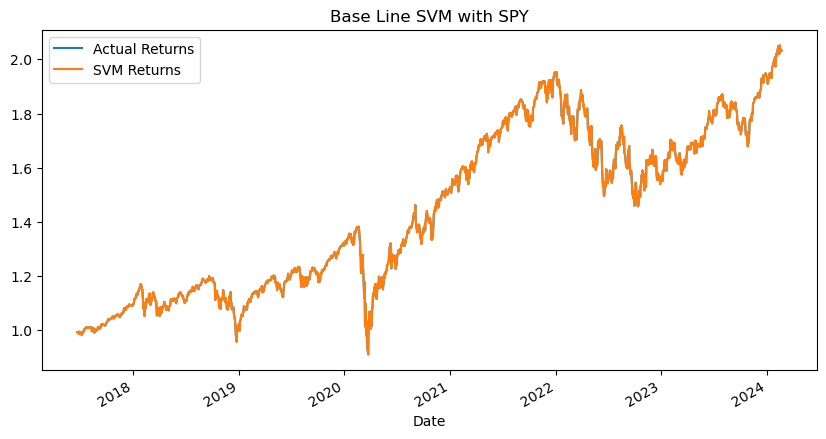

In [20]:
# Plot the actual returns versus the strategy returns
svm_comparison_plot=(1 + predictions_df[["Actual Returns", "SVM Returns"]]).cumprod().plot(figsize=(10,5),
    title="Base Line SVM with SPY")
svm_comparison_plot.get_figure().savefig("SVM_BaseLine_spy.png",bbox_inches="tight")

### Create The Logistic Regression Model

In [21]:
# Implementing Logistic Regression classifier from SKLearn

pipeline = Pipeline(steps=[('scaler', MinMaxScaler()),
                   ('model', LogisticRegression(random_state=7))])

# Fit the model to the data using the training data
pipeline.fit(X_train, y_train)

# Use the testing data to make the model predictions
lrm_pred = pipeline.predict(X_test)

# # Use a classification report to evaluate the model using the predictions and testing data
lrm_testing_report = classification_report(y_test, lrm_pred)
# Print the classification report
print(lrm_testing_report)

              precision    recall  f1-score   support

           0       0.50      0.93      0.65       812
           1       0.65      0.11      0.19       867

    accuracy                           0.51      1679
   macro avg       0.57      0.52      0.42      1679
weighted avg       0.57      0.51      0.41      1679



In [22]:
# Add LRM model predictions to the DataFrame
predictions_df['Predicted_LRM'] = lrm_pred

# Add the strategy returns to the DataFrame
predictions_df['LRM Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted_LRM']

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Actual Returns,Predicted_SVM,SVM Returns,Predicted_LRM,LRM Returns
Date,,,,,
2017-06-20,-0.006744,1,-0.006744,1,-0.006744
2017-06-21,-0.000247,1,-0.000247,1,-0.000247
2017-06-22,-0.000453,1,-0.000453,1,-0.000453
2017-06-23,0.001194,1,0.001194,1,0.001194
2017-06-26,0.000658,1,0.000658,1,0.000658


,Actual Returns,Predicted_SVM,SVM Returns,Predicted_LRM,LRM Returns
Date,,,,,
2024-02-14,0.009088,1,0.009088,0,0.0
2024-02-15,0.006900,1,0.006900,0,0.0
2024-02-16,-0.004980,1,-0.004980,0,-0.0
2024-02-20,-0.005505,1,-0.005505,0,-0.0
2024-02-21,0.000906,1,0.000906,0,0.0


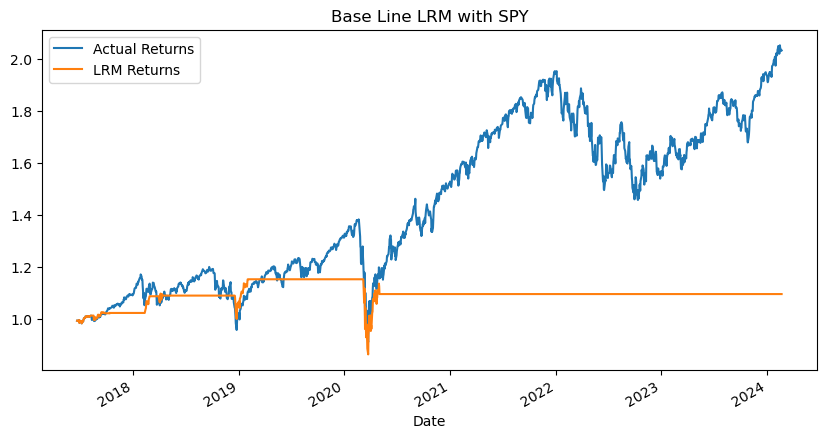

In [23]:
# Plot the actual returns versus the strategy returns
lrm_comparison_plot=(1 + predictions_df[["Actual Returns", "LRM Returns"]]).cumprod().plot(figsize=(10,5),
    title="Base Line LRM with SPY")
lrm_comparison_plot.get_figure().savefig("LRM_BaseLine_spy.png",bbox_inches="tight")

### Create The MLP Classifier

In [24]:
# From SkLearn-Neural Network, instantiate MLP classifier

pipeline = Pipeline(steps=[('scaler', MinMaxScaler()),
                   ('model', MLPClassifier(random_state=7))])

# Fit the model to the data using the training data
pipeline.fit(X_train, y_train)
# Use the testing data to make the model predictions
mlp_pred = pipeline.predict(X_test)

# # Use a classification report to evaluate the model using the predictions and testing data
mlp_testing_report = classification_report(y_test, mlp_pred)
# Print the classification report
print(mlp_testing_report)

              precision    recall  f1-score   support

           0       0.57      0.36      0.44       812
           1       0.55      0.74      0.63       867

    accuracy                           0.56      1679
   macro avg       0.56      0.55      0.54      1679
weighted avg       0.56      0.56      0.54      1679



In [25]:
# Add LRM model predictions to the DataFrame
predictions_df['Predicted_MLP'] = mlp_pred

# Add the strategy returns to the DataFrame
predictions_df['MLP Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted_MLP']

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Actual Returns,Predicted_SVM,SVM Returns,Predicted_LRM,LRM Returns,Predicted_MLP,MLP Returns
Date,,,,,,,
2017-06-20,-0.006744,1,-0.006744,1,-0.006744,1,-0.006744
2017-06-21,-0.000247,1,-0.000247,1,-0.000247,1,-0.000247
2017-06-22,-0.000453,1,-0.000453,1,-0.000453,1,-0.000453
2017-06-23,0.001194,1,0.001194,1,0.001194,1,0.001194
2017-06-26,0.000658,1,0.000658,1,0.000658,1,0.000658


,Actual Returns,Predicted_SVM,SVM Returns,Predicted_LRM,LRM Returns,Predicted_MLP,MLP Returns
Date,,,,,,,
2024-02-14,0.009088,1,0.009088,0,0.0,0,0.0
2024-02-15,0.006900,1,0.006900,0,0.0,0,0.0
2024-02-16,-0.004980,1,-0.004980,0,-0.0,0,-0.0
2024-02-20,-0.005505,1,-0.005505,0,-0.0,0,-0.0
2024-02-21,0.000906,1,0.000906,0,0.0,0,0.0


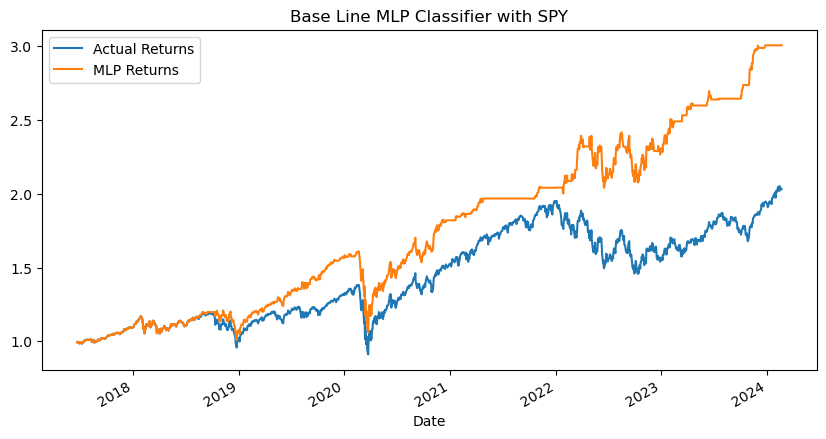

In [26]:
# Plot the actual returns versus the strategy returns
mlp_comparison_plot=(1 + predictions_df[["Actual Returns", "MLP Returns"]]).cumprod().plot(figsize=(10,5),
    title="Base Line MLP Classifier with SPY")
mlp_comparison_plot.get_figure().savefig("MLP_BaseLine_spy.png",bbox_inches="tight")

### Actual returns vs Stratagey Returns

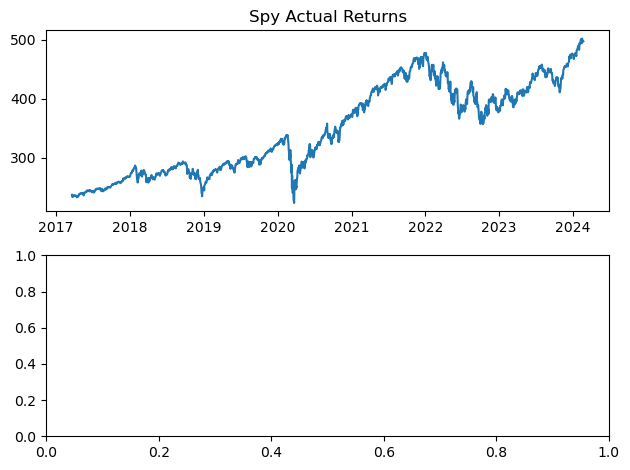

In [27]:

import matplotlib.pyplot as plt

closing = spy["Actual Returns"].hvplot()



x = np.linspace(0.0, 5.0, 100)
y = np.cos(2*np.pi*x) * np.exp(-x)
fig, axs = plt.subplots(2)
axs[0].set_title('Spy Actual Returns')


axs[0].plot(spy["Close"])


plt.tight_layout()




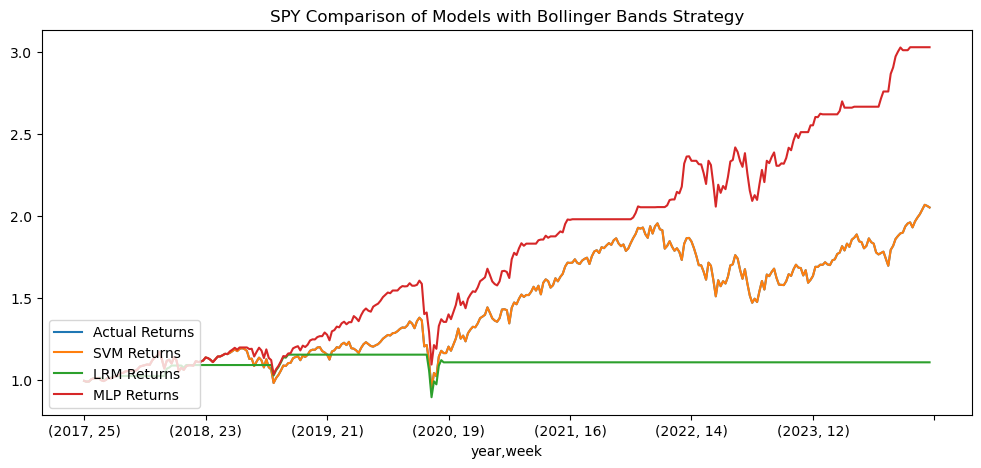

In [34]:
# Comparison of Different Models


weekly_returns = predictions_df.groupby(
    by=[
        predictions_df.index.isocalendar().year,
        predictions_df.index.isocalendar().week
    ]
).sum()

comparison_plot=(1 + weekly_returns[["Actual Returns","SVM Returns","LRM Returns","MLP Returns"]]
                 ).cumprod().plot(figsize=(12,5),
    title="SPY Comparison of Models with Bollinger Bands Strategy")
comparison_plot.legend(loc='lower left')
comparison_plot.get_figure().savefig("Comparison_Chart_spy.png",bbox_inches="tight")

# weekly_returns.head(2)

# stratagy metrics

In [29]:
def indicator(data):
    # data is our dataframe
    spy
    print(spy)
    return spy.to_numpy().T[:3]

class SignalStratagy(Strategy):
    def init(self):
        pass
        
    
    def next(self):
        
        lower_band = self.data.lowerband
        upper_band = self.data.upperband
       
        current_signal = self.data.signals[-1]
        if current_signal == 1:
            if not self.position:
                self.sell()
                
        if current_signal == 2:
            if not self.position:
                self.buy()
                
        elif current_signal == -2:
            if self.position:
                self.position.close()
        
        elif current_signal == -1:
            if self.position:
                self.position.close()

            

    
bt = Backtest(spy, SignalStratagy, cash = 100_000)

stats = bt.run()
bt.plot()
print(stats)

Start                     2017-03-20 00:00:00
End                       2024-02-21 00:00:00
Duration                   2529 days 00:00:00
Exposure Time [%]                   55.880666
Equity Final [$]                125358.496384
Equity Peak [$]                 129216.147354
Return [%]                          25.358496
Buy & Hold Return [%]              109.997036
Return (Ann.) [%]                    3.321549
Volatility (Ann.) [%]                16.65621
Sharpe Ratio                         0.199418
Sortino Ratio                        0.297073
Calmar Ratio                         0.107341
Max. Drawdown [%]                  -30.943825
Avg. Drawdown [%]                   -3.280578
Max. Drawdown Duration      699 days 00:00:00
Avg. Drawdown Duration       62 days 00:00:00
# Trades                                   61
Win Rate [%]                        68.852459
Best Trade [%]                       6.830622
Worst Trade [%]                    -12.722007
Avg. Trade [%]                    

In [32]:
# Visualize entry position relative to close price
entry = spy[spy["signals"] == 2.0 ]["Close"].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
exit = spy[spy["signals"] == -2.0]["Close"].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = spy[["Close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

bb_upper = spy[["upperband"]].hvplot(
    line_color='purple',
    ylabel='Price in $',
    width=1000,
    height=400
)


sma = spy[["sma20"]].hvplot(
    line_color='orange',
    ylabel='Price in $',
    width=1000,
    height=400
)

bb_lower = spy[["lowerband"]].hvplot(
    line_color='blue',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry_2 = spy[spy["signals"] == 1.0]["Close"].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
exit_2 = spy[spy["signals"] == -1.0]["Close"].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close_2 = spy[["Close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

bb_upper_2 = spy[["upperband"]].hvplot(
    line_color='purple',
    ylabel='Price in $',
    width=1000,
    height=400
)


sma_2 = spy[["sma20"]].hvplot(
    line_color='orange',
    ylabel='Price in $',
    width=1000,
    height=400
)

bb_lower_2 = spy[["lowerband"]].hvplot(
    line_color='blue',
    ylabel='Price in $',
    width=1000,
    height=400
)


# Overlay plots
bbands_plot_2 = security_close_2  * bb_upper_2  * sma_2  * bb_lower_2  * entry_2  * exit_2 
bbands_plot = security_close  * bb_upper  * sma  * bb_lower  * entry  * exit 


bbands_plot_2 * bbands_plot


:Overlay
   .Curve.I           :Curve   [index]   (Close)
   .Curve.II          :Curve   [index]   (upperband)
   .Curve.III         :Curve   [index]   (sma20)
   .Curve.IV          :Curve   [index]   (lowerband)
   .Scatter.Close.I   :Scatter   [index]   (Close)
   .Scatter.Close.II  :Scatter   [index]   (Close)
   .Curve.V           :Curve   [index]   (Close)
   .Curve.VI          :Curve   [index]   (upperband)
   .Curve.VII         :Curve   [index]   (sma20)
   .Curve.VIII        :Curve   [index]   (lowerband)
   .Scatter.Close.III :Scatter   [index]   (Close)
   .Scatter.Close.IV  :Scatter   [index]   (Close)